In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.style.use('ggplot')
import seaborn as sns
import statistics

In [2]:
results = pd.read_csv("test_results/pg_duck_tpch_test_results.csv") 
test_name = "postgres_duck_db"

results = results.rename(columns={"Average": "Mean"})

In [3]:
print(len(results))
results.head()

88


,Data Type,Scaling Factor,Query Name,Query Number,Mean,Correct,Executed,Runs
0,SQL,1,Postgres,Query 1,4.940,True,Yes,"[4.927645921707153, 4.926247835159302, 4.88816..."
1,SQL,1,Duck DB,Query 1,0.115,True,Yes,"[0.13856959342956543, 0.11021685600280762, 0.1..."
2,Pandas,1,Pandas Converted (Duck DB),Query 1,1.740,True,Yes,"[2.0405163764953613, 1.715205430984497, 1.7075..."
3,Pandas,1,Pandas Converted (Postgres),Query 1,2.650,True,Yes,"[2.7840735912323, 2.6020681858062744, 2.603076..."
4,SQL,1,Postgres,Query 2,0.997,True,Yes,"[1.027843952178955, 0.9896767139434814, 0.9946..."


In [4]:
# Filter for Correct == True and Executed == Yes
results = results[(results.Correct == True) & (results.Executed == "Yes")]
print(len(results))
results

88


,Data Type,Scaling Factor,Query Name,Query Number,Mean,Correct,Executed,Runs
0,SQL,1,Postgres,Query 1,4.9400,True,Yes,"[4.927645921707153, 4.926247835159302, 4.88816..."
1,SQL,1,Duck DB,Query 1,0.1150,True,Yes,"[0.13856959342956543, 0.11021685600280762, 0.1..."
2,Pandas,1,Pandas Converted (Duck DB),Query 1,1.7400,True,Yes,"[2.0405163764953613, 1.715205430984497, 1.7075..."
3,Pandas,1,Pandas Converted (Postgres),Query 1,2.6500,True,Yes,"[2.7840735912323, 2.6020681858062744, 2.603076..."
4,SQL,1,Postgres,Query 2,0.9970,True,Yes,"[1.027843952178955, 0.9896767139434814, 0.9946..."
...,...,...,...,...,...,...,...,...
83,Pandas,1,Pandas Converted (Postgres),Query 21,3.0100,True,Yes,"[3.2295148372650146, 2.968352794647217, 2.9685..."
84,SQL,1,Postgres,Query 22,0.1930,True,Yes,"[0.21178245544433594, 0.19026589393615723, 0.1..."
85,SQL,1,Duck DB,Query 22,0.0633,True,Yes,"[0.061603546142578125, 0.06894564628601074, 0...."
86,Pandas,1,Pandas Converted (Duck DB),Query 22,0.3360,True,Yes,"[0.4075136184692383, 0.32442307472229004, 0.32..."


In [5]:
# Sort Query Name column to in-order
def extract_number(name):
    return int(name.split(" ")[1])

results['Query Number'] = results.apply(lambda row : extract_number(row['Query Number']), axis = 1)
results = results.sort_values(['Query Number'])

# Fix the runs column
def fix_runs(runs):
    new_runs = list(str(str(runs)[1:-1]).split(","))
    for i in range(0, len(new_runs)):
        new_runs[i] = float(new_runs[i].strip())
    return new_runs

results['Runs'] = results.apply(lambda row : fix_runs(row['Runs']), axis = 1)

results['Median'] = results.apply(lambda row: statistics.median(sorted(row['Runs'])), axis = 1)

def ignore_first_mean(runs):
    return statistics.mean(runs[1:])

results['Mean_first'] = results.apply(lambda row : ignore_first_mean(row['Runs']), axis = 1)

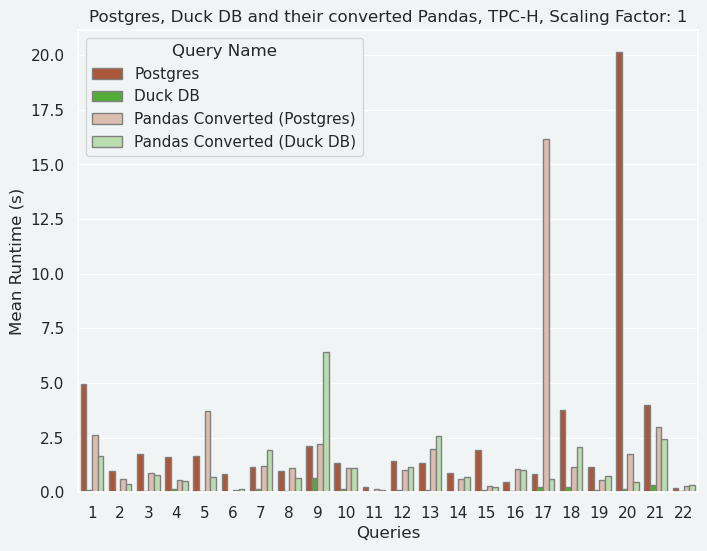

In [6]:
# plot with seaborn barplot
sns.set(rc={'figure.figsize':(8,6)})
background_color = '#f1f4f5'
sns.set(rc={'axes.facecolor':background_color, 'figure.facecolor':background_color})

color = ['#be4d25','#49be25','#e5b8a8', '#b6e5a8']
order = ["Postgres", "Duck DB", "Pandas Converted (Postgres)", "Pandas Converted (Duck DB)"]

ax = sns.barplot(data=results, x='Query Number', y='Mean_first', hue='Query Name',
                 palette=color, hue_order=order,edgecolor=".5")
#ax.set_yscale("log")
ax.set(xlabel='Queries', ylabel='Mean Runtime (s)')
plt.title("Postgres, Duck DB and their converted Pandas, TPC-H, Scaling Factor: 1")
#set parameters for tick labels
plt.tick_params(axis='x', which='major', labelsize=11)
#plt.tick_params(axis='y', which='major', labelsize=10)
plt.savefig("analysis_results/" + str(test_name) + "_compare_queries.pdf")
plt.show()

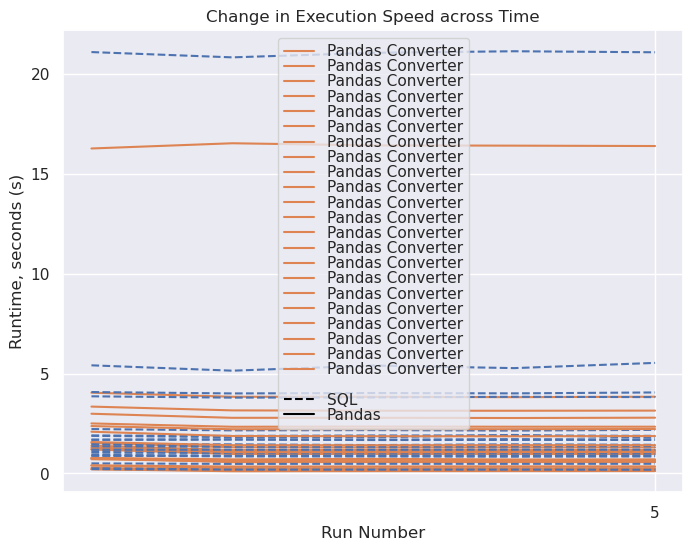

In [8]:
# Make graph of change in runtimes
# Y: Run time, X: Run Number
# Line: Query Number
prev_colors = {}

fig, ax = plt.subplots()

for index, row in results.iterrows():
    if row["Data Type"] == "SQL":
        line_style = 'dashed'
        legend_info = None
    else:
        line_style = 'solid'
        legend_info = row["Query Name"]
    
    # Choose line color
    if prev_colors.get(row["Query Name"], None) == None:
        # Not in dataframe
        line = ax.plot(list(range(1, len(row["Runs"])+1)), row["Runs"], label=legend_info, linestyle=line_style)
        prev_colors[row["Query Name"]] = line[0].get_color()
    else:
        color_line = prev_colors[row["Query Name"]]
        ax.plot(list(range(1, len(row["Runs"])+1)), row["Runs"], label=legend_info, linestyle=line_style, color=color_line)

# Add extra info to legend
ax.plot([], [], " ", label=" "*5,)
ax.plot([], [], label="SQL", color="black", linestyle="dashed")
ax.plot([], [], label="Pandas", color="black", linestyle="solid")

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(1))

plt.title('Change in Execution Speed across Time')
plt.xlabel('Run Number')
plt.ylabel('Runtime, seconds (s)')
ax.legend(labelspacing=0.01)
plt.savefig("analysis_results/" + str(test_name) + "_compare_queries_exec_time.pdf")
plt.show()